In [1]:
import sys
sys.path.append('/Users/vdk/GeneveWork/Code/calibpipe-main-calibpipe/')
from astropy.io import ascii
import numpy as np
import pandas as pd
import matplotlib
import csv
import scipy
import matplotlib.pyplot as plt
import random
import copy
from os import path, makedirs
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from ctapipe.containers import MuonEfficiencyContainer
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from ctapipe.io import EventSource, EventSeeker
from ctapipe.core import TelescopeComponent
from ctapipe.core.traits import (
    List,
    Int,
    FloatTelescopeParameter,
    TelescopeParameter,
    Unicode,
)
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.muon import MuonRingFitter, MuonIntensityFitter
from traitlets.config import Config
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.calib import CameraCalibrator
from traitlets.config.loader import Config, FileConfigLoader, JSONFileConfigLoader
import pathlib
from calibpipe.throughput import MuonCalibrator
from traitlets.config import Config

TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


BROKEN PIXELS [False False False ... False False False]
TYPE BROK PIXELS <class 'numpy.ndarray'>


ValueError: Image has a different shape () than the given CameraGeometry (1855,)

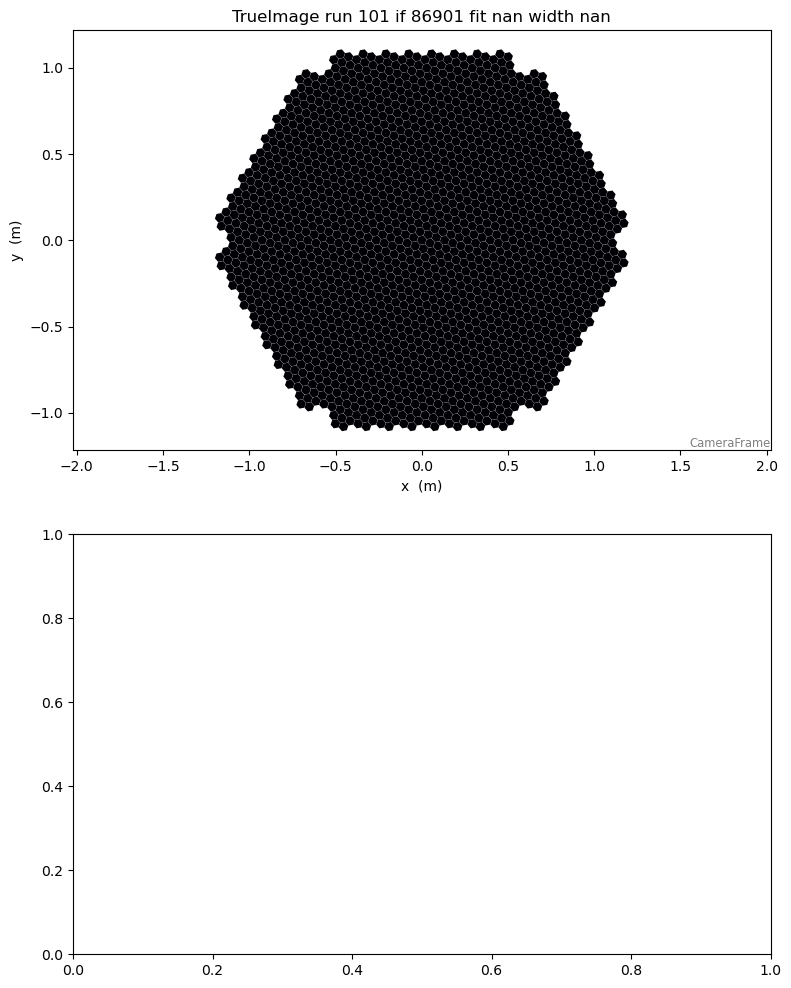

In [3]:
#filename = '/Users/vdk/MST_work/data_muons/mono_proton_simtel/proton_20deg_0deg_run2___cta-prod6-paranal-2147m-Paranal-nshow-3000-0-LSTs-1-MSTs-0-SSTs-NSCAT_5_CSCAT_300_EMIN_1_EMAX_200_after_muontag.simtel.zst'
#filename = '/Users/vdk/MST_work/data_muons/mono_muon_simtel/muon_20deg_0deg_run0___cta-prod6-paranal-2147m-Paranal-0-LSTs-1-MSTs-0-SSTs-NSCAT_1_CSCAT_8_EMIN_0.005_EMAX_1_FIXCHI_600_VIEWCONE_3_after_muontag.simtel.zst'
filename = '/Users/vdk/sim_run_folder/corsika_theta_28.4_az_182.75_run1.simtel.gz'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)



for i,j in enumerate(event_iterator):
    if i == 1:
        event = j
        image_processor = ImageProcessor(source.subarray)
        muon_processor = MuonProcessor(source.subarray)
        calib = CameraCalibrator(
                image_extractor_type="GlobalPeakWindowSum",
                subarray = source.subarray)
        calib(j)
        image_processor(j)
        muon_processor(j)
        fig, axes = plt.subplots(2, 1, sharex=False, gridspec_kw={'height_ratios': [1, 1]}, figsize=(9,12))
        fig.subplots_adjust(hspace=0.2)
        ax = axes[0]
        camgeom = source.subarray.tel[1].camera.geometry
        title="TrueImage run {} if {} fit {} width {}".format(j.index.obs_id, j.index.event_id, round(j.muon.tel[1].efficiency.optical_efficiency, 3), round(j.muon.tel[1].efficiency.width.to_value(),3))
        disp = CameraDisplay(camgeom,title=title, ax = ax)
        disp.image = j.simulation.tel[1].true_image #.sum(axis=1)
        #disp.image = event.dl1.tel[1].image
        disp.cmap = plt.cm.RdBu_r
        disp.add_colorbar()
        disp.set_limits_percent(95)
        bx = axes[1]
        for pix_id in range(0,1764):
            bx.plot(j.r0.tel[1].waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle='steps')
        bx.set_ylabel("ADC counts")
        bx.set_xlabel("Samples")
        bx.set_title("Waveforms")
        plt.show()
        #plt.savefig(f"/Users/vdk/MST_ProtonImages_NewQualityCheck/TrueImage+Waveform_mstPROTON_event{j.index.event_id}_obs{j.index.obs_id}_numer{i}")
        #plt.savefig(f"/Users/vdk/TrueImage+Waveform_mstMUON_event{j.index.event_id}_obs{j.index.obs_id}")
        break
        #if i == 150:
        #    break

plt.close()

In [ ]:
plt.pcolormesh(event.r0.tel[1].waveform[0])  # note the [0] is for channel 0
plt.colorbar()
plt.xlabel("sample number")
plt.ylabel("Pixel_id")

In [ ]:
for pix_id in range(185,195):
    plt.plot(event.r0.tel[1].waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle='steps')
#plt.legend()

test_image = np.zeros((1764,25))
test_true_image = np.zeros(1764)
edit_image = event.simulation.tel[1].true_image.copy()
edit_image.shape

In [ ]:
plt.figure(figsize = (10,7))
camgeom = source.subarray.tel[1].camera.geometry
#title="CT{}, run {} event {}".format(tel,event.index.obs_id,event.index.event_id)
disp = CameraDisplay(camgeom,title=title)
disp.image = event.simulation.tel[1].true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)

In [ ]:
edit_image = event.simulation.tel[1].true_image.copy()
true_image = event.simulation.tel[1].true_image
# INDICES for central contamination of event 93 from obs94 protonMST file
indices1 = [i for i in range(160,175)]
indices2 = [i for i in range(1243, 1260)]
indices3 = [i for i in range(180,192)]
indices4 = [i for i in range(196,200)]
indices = indices1+indices2+indices3+indices4
#np.put(edit_image, indices1, [0])
#np.put(edit_image, indices2, [0])
#np.put(edit_image, indices3, [0])
np.put(edit_image, indices, [0])
cont_image =  event.simulation.tel[1].true_image.copy()
ind = [i for i in range(1764)]
cont_ind = list(set(ind)-set(indices))
np.put(cont_image, cont_ind, [0]) 

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=False, gridspec_kw={'width_ratios': [1, 1]}, figsize=(12,5))
fig.subplots_adjust(hspace=0.2)
dx = axes[0]
camgeom = source.subarray.tel[1].camera.geometry
disp = CameraDisplay(camgeom,title=title, ax = dx)
disp.image = edit_image
#disp.image = true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
dx.set_title("Extracted muon ring")
cx = axes[1]
camgeom = source.subarray.tel[1].camera.geometry
disp = CameraDisplay(camgeom,title=title, ax = cx)
disp.image = cont_image
#disp.image = true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
cx.set_title("Extracted contamination")
#plt.show()
#plt.savefig("/Users/vdk/DistinctRingContamination")

In [ ]:
# only contamination region
for pix_id in indices:
    plt.plot(event.r0.tel[1].waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle='steps')
    #plt.ylim(320,1000)
#plt.legend()

In [ ]:
for pix_id in range(0,1760):
    if pix_id in indices:
        continue
    else:
        plt.plot(event.r0.tel[1].waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle='steps')
    #plt.ylim(320,1000)
#plt.legend()

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=False, gridspec_kw={'width_ratios': [1, 1]}, figsize=(12,5))
fig.subplots_adjust(hspace=0.2)
ax = axes[0]
for pix_id in range(0,1760):
    if pix_id in indices:
        continue
    else:
        ax.plot(event.r0.tel[1].waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle='steps')
ax.set_ylabel("ADC counts")
ax.set_xlabel("Samples")
ax.set_title("Only Ring")
#ax.set_ylim(320,1100)
bx = axes[1]
for pix_id in indices:
    plt.plot(event.r0.tel[1].waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle='steps')
#bx.set_ylabel("ADC counts")
#bx.set_ylim(320,1100)
bx.set_xlabel("Samples")
bx.set_title("Contamination")
plt.show()
#plt.savefig("/Users/vdk/WaveformsRingContaminationWithBackground")

# NEW EVENT

In [ ]:
filename = '/Users/vdk/MST_work/data_muons/mono_proton_simtel/proton_20deg_0deg_run2___cta-prod6-paranal-2147m-Paranal-nshow-3000-0-LSTs-1-MSTs-0-SSTs-NSCAT_5_CSCAT_300_EMIN_1_EMAX_200_after_muontag.simtel.zst'
#filename = '/Users/vdk/MST_work/data_muons/mono_muon_simtel/muon_20deg_0deg_run0___cta-prod6-paranal-2147m-Paranal-0-LSTs-1-MSTs-0-SSTs-NSCAT_1_CSCAT_8_EMIN_0.005_EMAX_1_FIXCHI_600_VIEWCONE_3_after_muontag.simtel.zst'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)



for i,j in enumerate(event_iterator):
    if i == 4:
        event2 = j
        image_processor = ImageProcessor(source.subarray)
        muon_processor = MuonProcessor(source.subarray)
        calib = CameraCalibrator(
                image_extractor_type="NeighborPeakWindowSum",
                subarray = source.subarray)
        calib(j)
        image_processor(j)
        muon_processor(j)
        fig, axes = plt.subplots(2, 1, sharex=False, gridspec_kw={'height_ratios': [1, 1]}, figsize=(9,12))
        fig.subplots_adjust(hspace=0.2)
        ax = axes[0]
        camgeom = source.subarray.tel[1].camera.geometry
        title="TrueImage run {} if {} fit {} width {}".format(j.index.obs_id, j.index.event_id, round(j.muon.tel[1].efficiency.optical_efficiency, 3), round(j.muon.tel[1].efficiency.width.to_value(),3))
        disp = CameraDisplay(camgeom,title=title, ax = ax)
        disp.image = j.simulation.tel[1].true_image #.sum(axis=1)
        #disp.image = event.dl1.tel[1].image
        disp.cmap = plt.cm.RdBu_r
        disp.add_colorbar()
        disp.set_limits_percent(95)
        bx = axes[1]
        for pix_id in range(0,1764):
            bx.plot(j.r0.tel[1].waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle='steps')
        bx.set_ylabel("ADC counts")
        bx.set_xlabel("Samples")
        bx.set_title("Waveforms")
        plt.show()
        #plt.savefig(f"/Users/vdk/MST_ProtonImages_NewQualityCheck/TrueImage+Waveform_mstPROTON_event{j.index.event_id}_obs{j.index.obs_id}_numer{i}")
        #plt.savefig(f"/Users/vdk/TrueImage+Waveform_mstMUON_event{j.index.event_id}_obs{j.index.obs_id}")
        break
        #if i == 150:
        #    break

plt.close()

In [ ]:
plt.figure(figsize = (10,7))
camgeom = source.subarray.tel[1].camera.geometry
#title="CT{}, run {} event {}".format(tel,event.index.obs_id,event.index.event_id)
disp = CameraDisplay(camgeom,title=title)
disp.image = event2.simulation.tel[1].true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)

test_image = np.zeros((1764,25))
test_true_image = np.zeros(1764)
edit_image2 = event2.simulation.tel[1].true_image.copy()
edit_image2.shape

In [ ]:
geometry = source.subarray.tel[1].camera.geometry
dir(geometry)

In [ ]:
print(geometry.position_to_pix_index)

In [ ]:
source.subarray.peek()

In [ ]:
plt.figure(figsize = (10,7))
display = CameraDisplay(geometry)
display.add_colorbar()
# right now, there might be one image per gain channel.
# This will change as soon as
for i in range(0,24):
    #display.image = event.r1.tel[1].waveform[:,i]
    display.image = event2.dl0.tel[1].waveform[:,i]
    display.cmap = plt.cm.RdBu_r
    plt.savefig(f'/Users/vdk/2obs112event{i}')
    

In [ ]:
event.dl0.tel[1].waveform.shape

In [ ]:
filename = '/Users/vdk/MST_work/data_muons/mono_proton_simtel/proton_20deg_0deg_run3___cta-prod6-paranal-2147m-Paranal-nshow-3000-0-LSTs-1-MSTs-0-SSTs-NSCAT_5_CSCAT_300_EMIN_1_EMAX_200_after_muontag.simtel.zst'
#filename = '/Users/vdk/MST_work/data_muons/mono_muon_simtel/muon_20deg_0deg_run0___cta-prod6-paranal-2147m-Paranal-0-LSTs-1-MSTs-0-SSTs-NSCAT_1_CSCAT_8_EMIN_0.005_EMAX_1_FIXCHI_600_VIEWCONE_3_after_muontag.simtel.zst'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)



for i,j in enumerate(event_iterator):
    if i == 131:
        event = j
        image_processor = ImageProcessor(source.subarray)
        muon_processor = MuonProcessor(source.subarray)
        calib = CameraCalibrator(
                image_extractor_type="NeighborPeakWindowSum",
                subarray = source.subarray)
        calib(j)
        image_processor(j)
        muon_processor(j)
        plt.figure(figsize = (10,7))
        camgeom = source.subarray.tel[1].camera.geometry
        #title="TrueImage run {} if {} fit {} width {}".format(j.index.obs_id, j.index.event_id, round(j.muon.tel[1].efficiency.optical_efficiency, 3), round(j.muon.tel[1].efficiency.width.to_value(),3))
        display = CameraDisplay(camgeom)
        display.add_colorbar()
        display.set_limits_percent(95)
        for k in range(0,24):
            display.image = event.dl0.tel[1].waveform[:,k]
            display.cmap = plt.cm.RdBu_r
            plt.savefig(f'/Users/vdk/{j.index.obs_id}obs{i}event{k}')
        bx.set_ylabel("ADC counts")
        bx.set_xlabel("Samples")
        bx.set_title("Waveforms")
        plt.show()
        #plt.savefig(f"/Users/vdk/MST_ProtonImages_NewQualityCheck/TrueImage+Waveform_mstPROTON_event{j.index.event_id}_obs{j.index.obs_id}_numer{i}")
        #plt.savefig(f"/Users/vdk/TrueImage+Waveform_mstMUON_event{j.index.event_id}_obs{j.index.obs_id}")
        break
        #if i == 150:
        #    break

plt.close()

In [ ]:
image_processor_config = Config(
    {
        "ImageProcessor": {
            "image_cleaner_type": "TailcutsImageCleaner",
            "TailcutsImageCleaner": {
                "picture_threshold_pe": [
                    ("type", "LST_LST_LSTCam", 7.5),
                    ("type", "MST_MST_FlashCam", 8),
                    ("type", "MST_MST_NectarCam", 8),
                    ("type", "SST_ASTRI_CHEC", 7),
                ],
                "boundary_threshold_pe": [
                    ("type", "LST_LST_LSTCam", 5),
                    ("type", "MST_MST_FlashCam", 4),
                    ("type", "MST_MST_NectarCam", 4),
                    ("type", "SST_ASTRI_CHEC", 4),
                ],
            },
        }
    }
)

#input_url = get_dataset_path("gamma_prod5.simtel.zst")
#source = EventSource(input_url)

calibrator = CameraCalibrator(subarray=source.subarray)
image_processor = ImageProcessor(
    subarray=source.subarray, config=image_processor_config
)
#shower_processor = ShowerProcessor(subarray=source.subarray)
#horizon_frame = AltAz()
image_processor